# Sleep stage classifier

## Aim of project

- Train a model to **classify** sleep data obtained from mice (*Mus musculus*) into wake, NREM sleep and REM sleep epochs. 

- Features  are derived from **continuous time series** muscle activty in the electromoyogram (EMG) and brain wave activity in the electroencephalogram (EEG). 

- An expert human sleep stage scorer classified each 5-second epoch into one of three classes (wake, NREM sleep or REM sleep) by visualizing the raw EEG and EMG.

- Manual classification of sleep is a labor-intensive process. Developing a model to accurately and automatically classify stages of sleep from mouse EEG and EMG recordings has the potential to save sleep scientists a lot of time!


## Features

The data is imported from a **.mat** file. Each feature, the target class, and start time are saved as separate dictionaries in this file. The features dictionaries and class dictionary hold **continuous time series data** which **start at the same time** but are sampled at different **sampling frequencies**.

- *Start*: The start time of all the features and the class

- *EMG*: Muscle activity, sampled at 500 Hz

- *Theta*: Brain wave activity in the theta band, sampled at 10 Hz

- *Delta*: Brain wave activity in the delta band, sampled at 10 Hz

- *T_D*: The theta: delta ratio, sampled at 10 Hz

- *Alpha*: Brain wave activity in the alpha and beta bands, sampled at 10 Hz

- *Low Gamma*: Brain wave activity in the low gamma band, sampled at 10 Hz

- *Stage*: The sleep stage (**target class**) that each 5-second epoch was assigned to by the expert human scorer 
    - *wake* = 1
    - *NREM sleep*  = 2
    - *REM sleep* = 3

#### Import libraries

In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#### Load data from MATLAB file and extract dictionaries


In [2]:
data = sio.loadmat('ls46_5onoff_data.mat')

for key in data.keys():
    if key.startswith('EMG'):           # extract feature dictionaries
        emg_dict = data[key]
    elif key.startswith('T_D'):
        td_dict = data[key]
    elif key.startswith('Delta'):
        delta_dict = data[key]
    elif key.startswith('Theta'):
        theta_dict = data[key]
    elif key.startswith('alpha'):
        alphabeta_dict = data[key]
    elif key.startswith('low_gamma'):
        low_gamma_dict = data[key]
    elif key.startswith('Stage'):            # extract class dictionary
        stage_dict = data[key]
    elif key.startswith('start'):             # extract start time
        start_dict = data[key]

## Extract feature data and align to the same timebase as the target class

Because the continuous time series feature and class data start at the same time but are sampled at different sampling frequencies, the feature data need to be aligned to the target class data.

The following code will extract the feature values from each feature dictionary and align it to the class data by summing the feature data every 5 seconds.

#### 1. Determine how many epochs have been classified

In [3]:
num_epochs = np.size(stage_dict['codes'][0][0][:],0)-1     # we can't use the last epoch as there isn't a full 5 seconds at the end of the recording

#### 2. Create a function to extract feature values and align to 5 second epochs

In [4]:
def align_features(feature_struct,num_epochs): 
    feature_data = feature_struct['values'][0][0][:,0]   # Extract feature data from each feature dictionary
    Hz = int(1/feature_struct['interval'][0][0][0][0])  # Determine the sampling interval of the data points in this feature
    datapoints_to_sum = Hz*5  # Calculate the number of data points in 5 seconds
    data_slice = feature_data[0:(datapoints_to_sum*num_epochs)]  # prepare array data to be reshaped into feature matrix
    feature_matrix = np.reshape(data_slice,(num_epochs,datapoints_to_sum))   # reshape data so can sum along rows
    aligned_feature = np.sum(feature_matrix,1)    # sum along each row to get 5 second sums
    return aligned_feature

#### 3. Apply *align_features* function to feature dictionaries

In [5]:
emg = align_features(emg_dict, num_epochs)
td = align_features(td_dict, num_epochs)
theta = align_features(theta_dict, num_epochs)
delta = align_features(delta_dict, num_epochs)
alphabeta = align_features(alphabeta_dict, num_epochs)
low_gamma = align_features(low_gamma_dict, num_epochs)

### Construct dataframe for features and class

In [6]:
d = {'emg': emg, 'td' : td, 'theta': theta, 'delta': delta, 
    'alphabeta': alphabeta, 'low_gamma': low_gamma}
df = pd.DataFrame(data=d)
df['class'] = stage_dict['codes'][0][0][:-1,0]
df.head()

,emg,td,theta,delta,alphabeta,low_gamma,class
0,16.282654,7.007887,0.196086,1.379307,0.125634,0.089396,1
1,2.715759,9.665851,0.460911,2.362047,0.218540,0.118814,2
2,-0.770569,12.110207,0.619068,2.566740,0.299538,0.155130,2
3,21.119690,14.197604,0.648419,2.287192,0.326630,0.160255,2
4,5.499268,16.312177,0.779486,2.386870,0.373140,0.179540,2


## Training a model to classify sleep stages: Support Vector Machine

#### 1. Perform Train Test Split to split our data into training data and test data

In [7]:
X = df[['emg', 'td', 'theta', 'delta', 'alphabeta', 'low_gamma']]
y = df['class']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 2. Perform feature scaling

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### 3. Train the Model using a Support Vector Machine

Because the number of samples (classfied epochs) is intermediate and the number of features small, I will first implement the SVM using a Gaussian kernel

In [11]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

#### 4. Make predictions on the test data (X_test) based on the fitted SVC model

In [12]:
clf_predictions = clf.predict(X_test)

#### 5. Evaluate predictions against actual test data (y_test) classifications

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))

[[ 632   33    5]
 [  40 1034    6]
 [   8    8  178]]
              precision    recall  f1-score   support

           1       0.93      0.94      0.94       670
           2       0.96      0.96      0.96      1080
           3       0.94      0.92      0.93       194

    accuracy                           0.95      1944
   macro avg       0.94      0.94      0.94      1944
weighted avg       0.95      0.95      0.95      1944



The data is quite skewed (more of category 2 (NREM sleep) than category 1 (wake) or category 3 (REM sleep)), hence the F1-score gives the most useful metric in determining how good our model was. Our model does not fit the data perfectly and there may be some room for improvement. To this end, we will adjust the parameters of our model using GridSearchCV to help us find the best hyperparameters.

## Gridsearch

In [14]:
parameters = {'kernel':('linear', 'rbf'), 'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001]}
from sklearn.model_selection import GridSearchCV
clf_grid = GridSearchCV(SVC(),parameters,refit=True,verbose=3)
clf_grid.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.942, total=   0.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.941, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.930, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.935, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.932, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.924, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.942, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.941, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.930, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.935, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=1, kernel=linear, score=0.938, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.943, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.946, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.938, total=   0.1s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.947, total=   0.1s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.948, total=   0.1s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.938, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] .

[CV] ...... C=1000, gamma=1, kernel=linear, score=0.948, total=   3.7s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.948, total=   4.4s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.936, total=   3.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.920, total=   0.3s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.918, total=   0.3s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.929, total=   0.3s
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] .... C=1000, gamma=0.1, kernel=linear, score=0.948, total=   3.1s
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [15]:
clf_grid.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

In [16]:
clf_grid.best_estimator_

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
clf_grid_predictions = clf_grid.predict(X_test)

In [18]:
print(confusion_matrix(y_test,clf_grid_predictions))
print(classification_report(y_test,clf_grid_predictions))

[[ 632   34    4]
 [  41 1033    6]
 [   9    8  177]]
              precision    recall  f1-score   support

           1       0.93      0.94      0.93       670
           2       0.96      0.96      0.96      1080
           3       0.95      0.91      0.93       194

    accuracy                           0.95      1944
   macro avg       0.94      0.94      0.94      1944
weighted avg       0.95      0.95      0.95      1944



It turns out that we were not able to improve the F1-score of the model by optimizing the hyperparameters. In order to improve our model, we will then consider what other features might yield useful information that could improve the success rate of our classifier.

## Engineering additional features

The time of day at which the features are recorded influences the likelihood of an epoch being classed as wake, NREM sleep or REM sleep (i.e. mice are nocturnal so during the day time they are more likely to be asleep). This being the case, we will extract a new feature, 'hour' which tells us what hour of the day it is.

#### Find start time of recording and extract what hour of the day it is for each sample
The start time of the recording can be obtained from the array, 'codes', in the dictionary, 'start_time'. The first 6 elements in 'codes' correspond to the 6-digit timestamp, HH:MM:SS. We first convert this 6 element array into a Python datetime. This is the start time of the recording ('t'). We next re-construct the actual time for each epoch in our DataFrame and extract the hour-of-the-day as a separate feature.

In [19]:
start_time = start_dict['codes'][0][0][0:6:,0]    # Extract 6-element time information from start_dict
start_hour = int(str(start_time[0]) + str(start_time[1]))  # Separate hour out
start_minute = int(str(start_time[2]) + str(start_time[3]))   # Separate minute out
start_second = int(str(start_time[4]) + str(start_time[5]))    # Separate second out
t = dt.datetime(1900,1,1,hour = start_hour,minute = start_minute,second = start_second)   # Convert start time to Python datetime object

elapsed_time = np.arange(0,(num_epochs),1)*5   # Construct time scale, indicating elapsed time in seconds (starting at 0, incrementing in 5-second intervals)
df['timestamp'] = elapsed_time                 # Make column for elapsed_time
df['timestamp'] = df['timestamp'].apply(lambda secs: t + dt.timedelta(0,secs)) # Convert elapsed_time into actual clock time by adding to start time 't'
df['hour'] = df['timestamp'].apply(lambda x: x.hour)   # extract hour from timestamp

The below plot shows the distribution of each class, every hour during the day

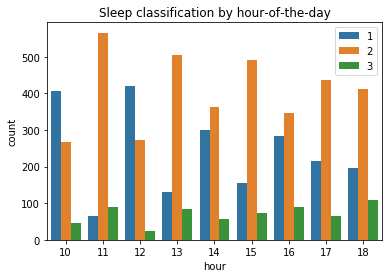

In [20]:
sns.countplot(x = 'hour', hue = 'class', data = df)
plt.legend(loc = 'upper right')
plt.title('Sleep classification by hour-of-the-day');

#### Effect of previous and future epochs on current epoch

When manually scoring the EEG and EMG and classifying each epoch to wake, NREM sleep or REM sleep, it is apparent that the classification of each epoch is not enitrely independent and is, to some degree, influenced by the epochs before and after it. For example, if both the epoch immediately prior to, and immediately after, a particular epoch are classed as 'wake', that epoch is also most likely a 'wake' epoch. This is demonstrated in the 'hypnogram' plot below where the class does not change over many epochs.

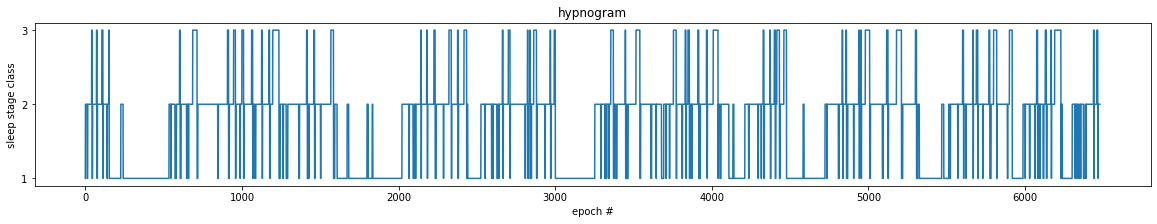

In [21]:
fig, ax = plt.subplots(figsize=(20,3))

ax.plot(df['class'])
ax.set_xlabel('epoch #')
ax.set_ylabel('sleep stage class')
ax.set_title('hypnogram');
ax.set_yticks([1, 2, 3]);

This property makes logical sense: after all, wake and sleep occur in consolidated bouts of several minutes long in the mouse.

Although the class of the surrounding epochs will be hidden from the model, we can provide the model with information about the prior and following epochs by engineering the existing features.

To this end, for each EEG/EMG feature, I will create two new features containing:

1) the moving average for the 10 seconds (2 epochs) preceding the start of the epoch

2) the moving average for the 10 seconds (2 epochs) following the start of the epoch

#### 1. Define a function to calculate the moving average over each feature

In [22]:
def pre_post_movavg(input_column):
    rolling_avg = input_column.rolling(2).mean()
    pre_movavg = np.append(rolling_avg[1:],np.nan)
    post_movavg = np.append(rolling_avg[4:],(np.zeros(4)+np.nan))
    return pre_movavg, post_movavg

#### 2. Apply 'pre_post_mov avg' to each EEG/EMG feature and add to feature dataframe

In [23]:
df['pre_emg'],df['post_emg'] = pre_post_movavg(df['emg'])
df['pre_td'],df['post_td'] = pre_post_movavg(df['td'])
df['pre_theta'],df['post_theta'] = pre_post_movavg(df['theta'])
df['pre_delta'],df['post_delta'] = pre_post_movavg(df['delta'])
df['pre_alphabeta'],df['post_alphabeta'] = pre_post_movavg(df['alphabeta'])
df['pre_low_gamma'],df['post_low_gamma'] = pre_post_movavg(df['low_gamma'])
df.dropna(inplace = True)      # remove NaN values introduced into the dataframe from the pre and post moving average 

## Retrain the SVC model with additional features

#### 1. Perform Train Test Split on the updated feature dataframe

In [24]:
X = df[['emg', 'td', 'theta', 'delta', 'alphabeta', 'low_gamma', 
       'hour', 'pre_emg', 'post_emg', 'pre_td', 'post_td', 'pre_theta', 'post_theta', 'pre_delta',
       'post_delta', 'pre_alphabeta', 'post_alphabeta', 'pre_low_gamma',
       'post_low_gamma']]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 2. Exploit sklearn Pipeline to perform feature scaling, fitting to an SVC, and using GridSearch to determine hyperparameters in one step

In [25]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(),SVC())
param_grid = {'svc__kernel':('linear', 'rbf'), 'svc__C': [0.1,1, 10, 100, 1000], 'svc__gamma': [1,0.1,0.01,0.001,0.0001]}
gs = GridSearchCV(pipe, param_grid,verbose=3)
gs.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=linear ....................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=linear, score=0.950, total=   0.1s
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=linear ....................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=linear, score=0.957, total=   0.1s
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=linear ....................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=linear, score=0.949, total=   0.1s
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=rbf .......................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=rbf, score=0.573, total=   0.7s
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=rbf .......................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=rbf, score=0.570, total=   0.7s
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=rbf .......................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=rbf, score=0.573, total=   0.8s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=li

[CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=linear, score=0.950, total=   0.1s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.896, total=   0.5s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.904, total=   0.4s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.882, total=   0.5s
[CV] svc__C=10, svc__gamma=1, svc__kernel=linear .....................
[CV]  svc__C=10, svc__gamma=1, svc__kernel=linear, score=0.952, total=   0.2s
[CV] svc__C=10, svc__gamma=1, svc__kernel=linear .....................
[CV]  svc__C=10, svc__gamma=1, svc__kernel=linear, score=0.959, total=   0.5s
[CV] svc__C=10, svc__gamma=1, svc__kernel=linear .....................
[CV]  svc__C=10, svc__gamma=1, svc__kernel=linear, score=0.947, total=   0.3s
[CV] svc__C=10, svc__

[CV]  svc__C=100, svc__gamma=0.001, svc__kernel=rbf, score=0.960, total=   0.2s
[CV] svc__C=100, svc__gamma=0.001, svc__kernel=rbf ...................
[CV]  svc__C=100, svc__gamma=0.001, svc__kernel=rbf, score=0.951, total=   0.1s
[CV] svc__C=100, svc__gamma=0.0001, svc__kernel=linear ...............
[CV]  svc__C=100, svc__gamma=0.0001, svc__kernel=linear, score=0.951, total=   1.1s
[CV] svc__C=100, svc__gamma=0.0001, svc__kernel=linear ...............
[CV]  svc__C=100, svc__gamma=0.0001, svc__kernel=linear, score=0.957, total=   1.4s
[CV] svc__C=100, svc__gamma=0.0001, svc__kernel=linear ...............
[CV]  svc__C=100, svc__gamma=0.0001, svc__kernel=linear, score=0.946, total=   1.1s
[CV] svc__C=100, svc__gamma=0.0001, svc__kernel=rbf ..................
[CV]  svc__C=100, svc__gamma=0.0001, svc__kernel=rbf, score=0.940, total=   0.1s
[CV] svc__C=100, svc__gamma=0.0001, svc__kernel=rbf ..................
[CV]  svc__C=100, svc__gamma=0.0001, svc__kernel=rbf, score=0.952, total=   0.1s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
   

In [26]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.01,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [27]:
pipe_predict = gs.predict(X_test)

In [28]:
print(confusion_matrix(y_test,pipe_predict))
print(classification_report(y_test,pipe_predict))

[[ 621   28    0]
 [  37 1057    7]
 [   7    5  181]]
              precision    recall  f1-score   support

           1       0.93      0.96      0.95       649
           2       0.97      0.96      0.96      1101
           3       0.96      0.94      0.95       193

    accuracy                           0.96      1943
   macro avg       0.96      0.95      0.95      1943
weighted avg       0.96      0.96      0.96      1943



The F1 scores improved by a couple of percentage points for both wake and REM sleep. Additionally, we can see from confusion matrix that wake (class 1) was never misclassified as REM sleep (class 3). On the other hand, NREM sleep and wake were sometimes misclassified as each other and REM sleep was also misclassified as either wake or NREM sleep.

Ways to improve the success of the classifier:

- Train the classifier on **more data**, specifically including data from around the whole 24 hour clock (only dat from between 10am and 4pm were included here)

- More intensive **engineering of existing features**. For example, 'hour of day' could be replaced by time periods of lower time resolutions (e.g. morning, afternoon, evening, night etc). Alternatively, it could make sense to combine EEG and EMG data into novel features. i.e. engineer a new feature that calculates the TD:EMG ratio. High values of TD are associated with both REM sleep *and* wake but high EMG values are only assoicated with wake (because there is very little muscle acitivity obsrved when mice are sleeping). Including this as a feature may enable better distinction between wake and REM sleep.

We will explore how including a newly engineered feature, TD:EMG ratio, will assist in training the classifier:

#### Calculate TD:EMG ratio (and pre and post TD:EMG ratios) and include in features

In [29]:
df['td_emg'] = df['td']/df['emg']
df['pre_td_emg'] = df['pre_td']/df['pre_emg']
df['post_td_emg'] = df['post_td']/df['post_emg']

In [30]:
X = df[['emg', 'td', 'theta', 'delta', 'alphabeta', 'low_gamma', 'class',
       'hour', 'pre_emg', 'post_emg', 'pre_td', 'post_td',
       'pre_theta', 'post_theta', 'pre_delta', 'post_delta', 'pre_alphabeta',
       'post_alphabeta', 'pre_low_gamma', 'post_low_gamma', 'td_emg',
       'pre_td_emg', 'post_td_emg']]
y = df['class']

#### Perform Train Test Split and utilize the previously instantiated 'pipe' to scale data and fit SVC with appropriate hyperparameters

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
new_gs = GridSearchCV(pipe, param_grid,verbose=3)
new_gs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=linear ....................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=linear, score=1.000, total=   0.0s
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=linear ....................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=linear, score=1.000, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] svc__C=0.1, svc__gamma=1, svc__kernel=linear ....................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=linear, score=1.000, total=   0.1s
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=rbf .......................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=rbf, score=0.573, total=   0.7s
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=rbf .......................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=rbf, score=0.573, total=   0.7s
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=rbf .......................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=rbf, score=0.574, total=   0.9s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=linear ..................
[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=linear, score=1.000, total=   0.0s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=linear ..................
[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=linear, score=1.000, total=   0.0s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=linear ..................
[CV]  svc__C=0.1, svc__gamma=0.1,

[CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.966, total=   0.4s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.967, total=   0.4s
[CV] svc__C=1, svc__gamma=0.0001, svc__kernel=rbf ....................
[CV]  svc__C=1, svc__gamma=0.0001, svc__kernel=rbf, score=0.947, total=   0.5s
[CV] svc__C=10, svc__gamma=1, svc__kernel=linear .....................
[CV]  svc__C=10, svc__gamma=1, svc__kernel=linear, score=1.000, total=   0.0s
[CV] svc__C=10, svc__gamma=1, svc__kernel=linear .....................
[CV]  svc__C=10, svc__gamma=1, svc__kernel=linear, score=1.000, total=   0.0s
[CV] svc__C=10, svc__gamma=1, svc__kernel=linear .....................
[CV]  svc__C=10, svc__gamma=1, svc__kernel=linear, score=1.000, total=   0.0s
[CV] svc__C=10, svc__gamma=1, svc__kernel=rbf ........................
[CV]  svc__C=10, svc__gamma=1, svc__kernel=rbf, score=0.839, total=   0.8s
[CV] svc__C=10, svc__gamma=1

[CV]  svc__C=100, svc__gamma=0.0001, svc__kernel=linear, score=1.000, total=   0.0s
[CV] svc__C=100, svc__gamma=0.0001, svc__kernel=linear ...............
[CV]  svc__C=100, svc__gamma=0.0001, svc__kernel=linear, score=1.000, total=   0.0s
[CV] svc__C=100, svc__gamma=0.0001, svc__kernel=rbf ..................
[CV]  svc__C=100, svc__gamma=0.0001, svc__kernel=rbf, score=1.000, total=   0.1s
[CV] svc__C=100, svc__gamma=0.0001, svc__kernel=rbf ..................
[CV]  svc__C=100, svc__gamma=0.0001, svc__kernel=rbf, score=1.000, total=   0.1s
[CV] svc__C=100, svc__gamma=0.0001, svc__kernel=rbf ..................
[CV]  svc__C=100, svc__gamma=0.0001, svc__kernel=rbf, score=1.000, total=   0.1s
[CV] svc__C=1000, svc__gamma=1, svc__kernel=linear ...................
[CV]  svc__C=1000, svc__gamma=1, svc__kernel=linear, score=1.000, total=   0.0s
[CV] svc__C=1000, svc__gamma=1, svc__kernel=linear ...................
[CV]  svc__C=1000, svc__gamma=1, svc__kernel=linear, score=1.000, total=   0.0s
[CV

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   25.2s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
   

In [32]:
new_gs.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=1,
                     kernel='linear', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [33]:
new_pipe_predict = new_gs.predict(X_test)

In [34]:
print(confusion_matrix(y_test,new_pipe_predict))
print(classification_report(y_test,new_pipe_predict))

[[ 649    0    0]
 [   0 1101    0]
 [   0    0  193]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       649
           2       1.00      1.00      1.00      1101
           3       1.00      1.00      1.00       193

    accuracy                           1.00      1943
   macro avg       1.00      1.00      1.00      1943
weighted avg       1.00      1.00      1.00      1943



## Summary

After including the TD:EMG feature, the model appears to be classifying the sleep data perfectly. Had this not been the cases, we could have tried to improve the classifier in several ways:

- including additional features such as heart rate and breathing rate
- engineer additional features from the EEG and EMG features similarly to the TD:EMG features
- Explore other modes (e.g. decision trees, random forest classifers, artificial neural networks)